<font size='5'><h1 ><center> **Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning : VGG-16 Transfer Learning**</center></h1></font>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#overview">Overview</a></li>
        <li><a href="#access-files-in-drive">Acces files in drive</a></li>
        <li><a href="#Preprocess_and_explo_data">Data preprocessing and exploring </a></li>
        <li><a href="#CNNimple">CNN Implementation</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#prediction">Prediction</a></li>
        <li><a href="#conclusion">Conclusion</a></li>
    </ol>
</div>
<br>

### **Overview**
Our project aims to create a solution that can easily detect covid-19 in an automated way, especially when the need for auxiliary diagnostic tools has increased as there are no accurate automated toolkits available. So, We are going to use Transfer Learning with the advanced and popular VGG16 architecture with pre-trained weights on the popular ImageNet dataset which is going to be on the base of our final model with another model on the top. This implementation uses Keras with a TensorFlow backend, and it will be performed Then adapted to our dataset which is full of X-ray images in Covid-19 and No_findings folders.
 
---

## **Data preprocessing and exploring**

### Access Files in Drive

---

In [ ]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


### Import required libraries and necessary packages

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

### Load The data

In [ ]:
#The path of our data on drive
data_dir =  r'/gdrive/My Drive/X-Ray_Image_DataSet'
 
#Loading Data
data = load_files(data_dir)

In [ ]:
folders=os.listdir("/gdrive/My Drive/X-Ray_Image_DataSet")
print(folders)

['Covid-19', 'No_findings']


>As you can see, our data set, contains two folders, **Covid-19** which contains X-ray images of people caught up with the virus, the **No_findings** which contains X-ray images of normal people

In [ ]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /gdrive/My Drive/X-Ray_Image_DataSet/No_findings/00002550_000.png
Target labels -  1
Number of training files :  625
Number of training targets :  625


#### We have one folder for each flower classe or type. We are going to load it into two numpy arrays as follows :    

- X - filenames (Training data)
- y - flower names(Target labels)

### Convert images to arrays

In [ ]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    # Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        # update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))
 
# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(625, 224, 224, 3)
First training item :  [[[35. 35. 35.]
  [32. 32. 32.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 [[30. 30. 30.]
  [26. 26. 26.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [23. 23. 23.]]

 [[22. 22. 22.]
  [22. 22. 22.]
  [24. 24. 24.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 ...

 [[24. 24. 24.]
  [27. 27. 27.]
  [55. 55. 55.]
  ...
  [67. 67. 67.]
  [78. 78. 78.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [25. 25. 25.]
  [41. 41. 41.]
  ...
  [76. 76. 76.]
  [82. 82. 82.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [30. 30. 30.]
  [25. 25. 25.]
  ...
  [77. 77. 77.]
  [81. 81. 81.]
  [73. 73. 73.]]]


#### **Few Take Aways**
#### Note that the shape of training data is **(625, 224, 224, 3)**
#####  
 
-   **625** is the **number** of training items or files,
-   **(224,224)** is the **target size** or image size provided while loading image
-   **3** refers to the **depth** for colored images ( RGB channels ).

### Take a look at some pictures

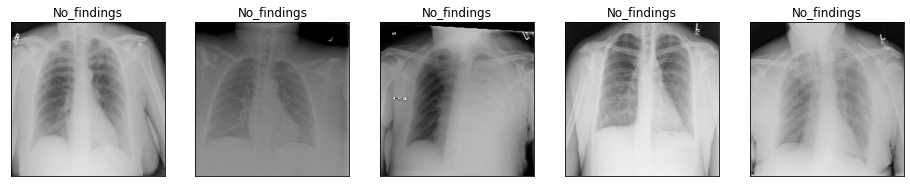

In [ ]:
# Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

> **rescale value** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor. So all values in X will lie within 0 to 1 !

In [ ]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

> Impressive! Our machine learning problem is a **binary classification problem**, we will detect whether a person is infected or not.

In [ ]:
y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,

 ### Let's converts a class vector (integers) to binary class matrix

In [ ]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1.], dtype=float32)

### Split the data into train, test and valid subsets
> Here we are going to split our dataset into **80% train**, **10% validation**, and **10% test**.

In [ ]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


In [ ]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


> **(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN

---

### **CNN Implementation**

### Fine tuning VGG16 pre-trained model
>Here we are going to use [**Transfer Learning**](https://keras.io/guides/transfer_learning/) with advanced and popular VGG16 architecture with pre-trained weights on the popular **ImageNet** dataset. Then adapt it to our dataset. So, it will be our base Model

In [ ]:
# load the VGG16 model without the final layers(include_top=False)
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
print("Base Model loaded !")
 
"""
  Loop over all layers in the base model and freeze them so they will
  not be updated during the first training process
"""
for layer in baseModel.layers:
    layer.trainable = False
    
baseModel.summary()

Base Model loaded !
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 5

### head Model
This Model we will put it later on the top of our base Model above. However, I will be using Sequential method as I am creating a sequential model. **Sequential model means that all the layers of the model will be arranged in sequence**, then i will add:
> - **AveragePooling2 layer of 4x4 pool size;**
- **Fully Connected :** 
>1. 1 x Flatten :
1. 1 x Dense of 64 units
1. 1 x Dropout  set at 50%
1. 1 x Dense of Softmax layer of 2 units
 
Few take aways :
>We are using **RELU** activation for the dense layer of 64 units so that I stop forwarding negative values through the network. I use a 2 unit dense layer in the end with softmax activation as I have 2 classes to predict from in the end which are **Covid-19** and **No-findings**. The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to.
 
>**Dropout** is a technique of regularisation which helps us to prevent **overfitting**.

In [ ]:
# In the summary above of our base model, trainable params is 0
""" Now, let's create a headModel to put on top of the base model
    (we are not freezing any layers of this model) 
"""
headModel = Sequential()
headModel.add(AveragePooling2D(pool_size=(4,4), input_shape=baseModel.output_shape[1:], name="AveragePooling2"))
headModel.add(Flatten( name ="Flatten"))
headModel.add(Dense(64, activation ="relu"))
headModel.add(Dropout(0.5, name="Dropout"))
headModel.add(Dense(no_of_classes, activation="softmax"))

headModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AveragePooling2 (AveragePool (None, 1, 1, 512)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
Dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 32,962
Trainable params: 32,962
Non-trainable params: 0
_________________________________________________________________


### Final Model
Here we are just going to put each model in its place, Yeah! We are talking about the base model (baseModel) and the head model (headModel). Therefor, we will put the first on the base and the second on the top. So, our final will look as showen below :

In [ ]:
# In the summary above of our base model, trainable params is 32, 962
""" Let's build the final model where we add the top_model on top of base_model.
    So, we will place the head Model on the top of the base Model. Therefore, this 
    'Model' will become the actual model we will train
"""
Model = Sequential()
Model.add(baseModel)
Model.add(headModel)
 
# I can check the summary of the final Model which we created by using the line of code below.
Model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 32962     
Total params: 14,747,650
Trainable params: 32,962
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile the model
Here we will be using **Adam** optimiser to reach to the global minima while training our model. If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima and reach global minima. We will also specify the learning rate of the optimiser, here in this case it is set at **1e-3 (0,001)**. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

In [ ]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(lr = lr, decay= lr/epochs)
Model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

---

### **Modelling**
>we are using **model.fit_generator** as we are using **ImageDataGenerator** to pass data to the model. I will pass **train** and **valid data** to **fit_generator**. In **fit_generator** **steps_per_epoch** will set the batch size to pass training data to the model and **validation_steps** will do the same for valid data. These settings could be changed according to each system specifications.
 
>For callbacks, we employed 
- **ModelCheckpoint :** Callback to save the model or model weights at certain frequencies. In this case, ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring val_loss by passing save_best_only = True to ModelCheckpoint. The model will only be saved to disk if the val_loss of the model in current epoch is lower than what it was in the last epoch. So, our modewe will be saved on **CDX_Best.h5** file in the path specified below.

In [ ]:
# Time to train our model !
epochs = 100
 
# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")
 
checkpointer = ModelCheckpoint(filepath = "/gdrive/My Drive/CDX_Best.h5", save_best_only = True, verbose=1)
start = time.time()
 
# let's get started !
 
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.8049WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0034s vs `on_test_batch_end` time: 0.0256s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.49550, saving model to /gdrive/My Drive/CDX_Best.h5
62/62 [==============================] - 6s 98ms/step - loss: 0.5313 - accuracy: 0.8049 - val_loss: 0.4955 - val_accuracy: 0.7143
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8252
Epoch 00002: val_loss improved from 0.49550 to 0.47399, saving model to /gdrive/My Drive/CDX_Best.h5
62/62 [==============================] - 6s 93ms/step - loss: 0.4134 - accuracy: 0.8252 - val_loss: 0.4740 - val_accuracy: 0.7302
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8394
Epoch 00003: val_loss did not improve from 0.47399
62/62 [==========================

**==> After training the model, we will be able to see the spectacular and the impressive performance reached ! :)**

---

### **Evaluation**
> The result of the script below shows the accuracy and loss of the test, using test data of course !

In [ ]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

8/8 - 0s - loss: 0.1069 - accuracy: 0.9839
Accuracy: 98.39%
Loss: 0.10685943067073822


- Test accuracy = 98,39%
- Test loss = 0.10685943067073822

### Accuracy and Loss graphs

>Also, after training the model, we will be able to see spectacular and impressive clarifications! reached

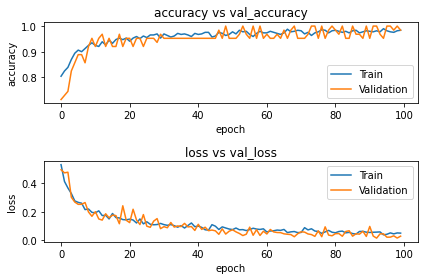

In [ ]:
# Let's visualize the train/validation loss and accuracy wrt epochs
 
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # Summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # Summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

**Few take aways :**
- From the Training and Validation Accuracy graph above, our model does not seem to be overfitted, which is great!;
- Our Training and Validation Loss graph above also indicates a good learning rate, which is amazing !

---

### **Prediction**
>Finally, let us test our model against more random samples from the test data !

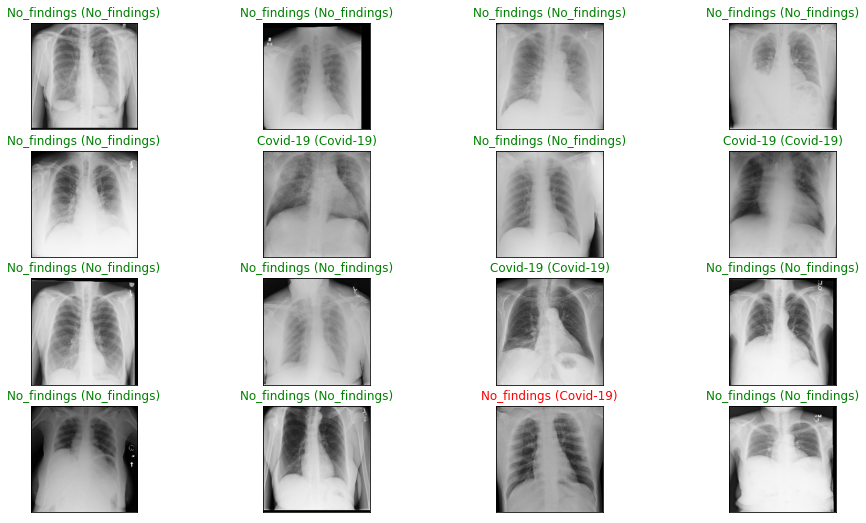

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# Plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
 
visualize_pred(Model.predict(X_test))

### Confusion Matrix
> Please note that, **_0_ and _1_ values represent _Covid-19_ and _No_findigs_ respectively**  .

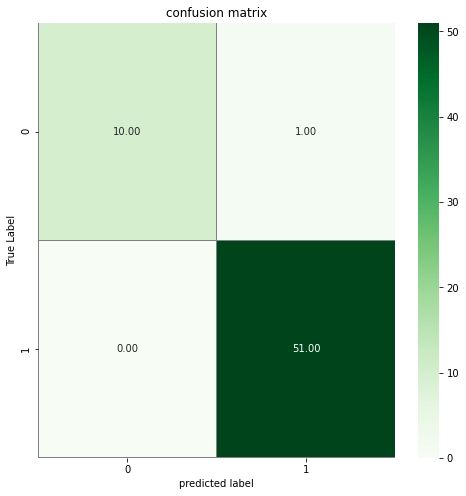

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

**Few Take aways:**
- The easiest to detect is **Covid-19**, i.e. if you are infected then you are really infected
- It is clear that the model can sometimes deceive in stating that a person is not infected but it could be. Anyways, we need the expertise to explain this kind of stuff, especially when it comes to medicine. **Just we must not forget that we do not have enough images for Covid-19**.

- Our confusion matrix indicates that there are disturbing errors. which is Great!.

> You can check the classification report below for more information !

In [ ]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       1.00      0.91      0.95        11
 No_findings       0.98      1.00      0.99        51

    accuracy                           0.98        62
   macro avg       0.99      0.95      0.97        62
weighted avg       0.98      0.98      0.98        62



### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

In [ ]:
my_model=keras.models.load_model('/gdrive/My Drive/CDX_Best.h5')

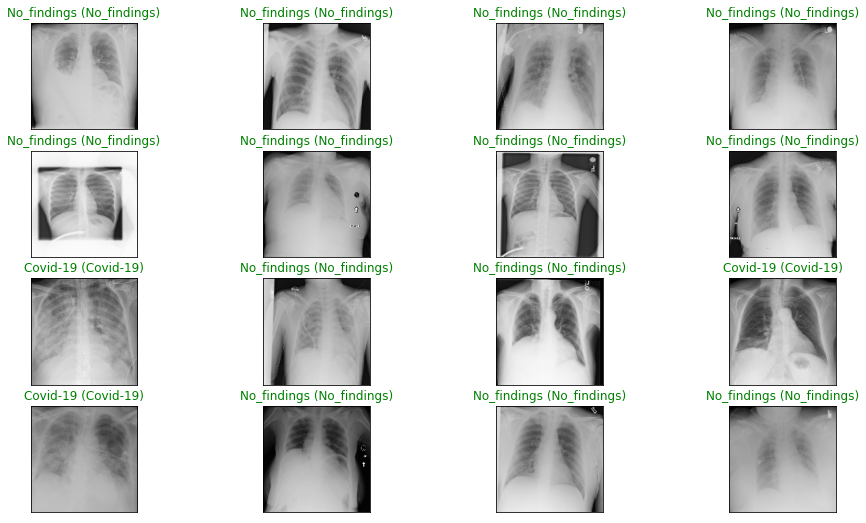

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))

**======> These are great results :)** 

## **Conclusion**
The classification precision achieved is great! at all levels
>This project can be considered quite successful, and it's ready to be deployed.

## **Thank you a lot for your interest** ☻